# Processing INAM rainfall data

This notebook reads in the geotiffs provided by INAM via Gabriela, WFP and produces values around the landfall date and 250km around the landfall location.

In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
from dotenv import load_dotenv
from pathlib import Path
import geopandas as gpd
import rioxarray as rxr
import numpy as np
import warnings
from shapely.geometry import Point
from datetime import timedelta

load_dotenv()
ADMS = ["Sofala", "Inhambane", "Nampula", "Zambezia"]
AA_DATA_DIR = Path(os.getenv("AA_DATA_DIR"))

In [3]:
warnings.filterwarnings("ignore")

In [4]:
adm1_path = (
    AA_DATA_DIR
    / "public"
    / "raw"
    / "moz"
    / "cod_ab"
    / "moz_admbnda_adm1_ine_20190607.shp"
)

gdf_adm1 = gpd.read_file(adm1_path)
gdf_sel = gdf_adm1[gdf_adm1.ADM1_PT.isin(ADMS)]
ibtracs_path = (
    Path(AA_DATA_DIR)
    / "public"
    / "raw"
    / "glb"
    / "ibtracs"
    / "IBTrACS.SI.list.v04r01.points/IBTrACS.SI.list.v04r01.points.shp"
)
gdf_ibtracs = gpd.read_file(ibtracs_path)
adm2_path = (
    AA_DATA_DIR
    / "public"
    / "raw"
    / "moz"
    / "cod_ab"
    / "moz_admbnda_adm2_ine_20190607.shp"
)

gdf_adm2 = gpd.read_file(adm2_path)
gdf_sel_adm2 = gdf_adm2[gdf_adm2.ADM1_PT.isin(ADMS)]

minx, miny, maxx, maxy = gdf_sel.total_bounds

In [5]:
all_storms = [
    "FAVIO",
    "JOKWE",
    "IZILDA",
    "DANDO",
    "IRINA",
    "HARUNA",
    "DELIWE",
    "GUITO",
    "HELLEN",
    "CHEDZA",
    "DINEO",
    "DESMOND",
    "IDAI",
    "KENNETH",
    "CHALANE",
    "ELOISE",
    "GUAMBE",
    "ANA",
    "GOMBE",
    "JASMINE",
    "FREDDY",
    "FILIPO",
]

<Axes: >

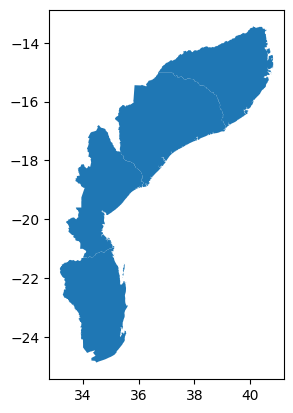

In [7]:
gdf_sel.plot()

In [8]:
landfall_df = pd.read_csv(
    AA_DATA_DIR
    / "public"
    / "processed"
    / "moz"
    / "landfall_time_location_fixed.csv"
)
inam_path = (
    AA_DATA_DIR
    / "private"
    / "raw"
    / "moz"
    / "inam"
    / "OCHA_blended_moz_updated"
    / "OCHA_blended_moz"
)

In [8]:
inam_files = files = os.listdir(inam_path)

In [10]:
inam_files[0].split("_")[-1].split(".")[0]

'20021230'

In [11]:
da_in = rxr.open_rasterio(
    inam_path / "chirp_daily_blended_moz_20030101.tif", masked=True
)

In [13]:
da_in

<xarray.DataArray (band: 1, y: 329, x: 213)> Size: 561kB
[70077 values with dtype=float64]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 2kB 30.23 30.28 30.33 30.38 ... 40.73 40.78 40.83
  * y            (y) float64 3kB -10.48 -10.53 -10.58 ... -26.78 -26.83 -26.88
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      precip

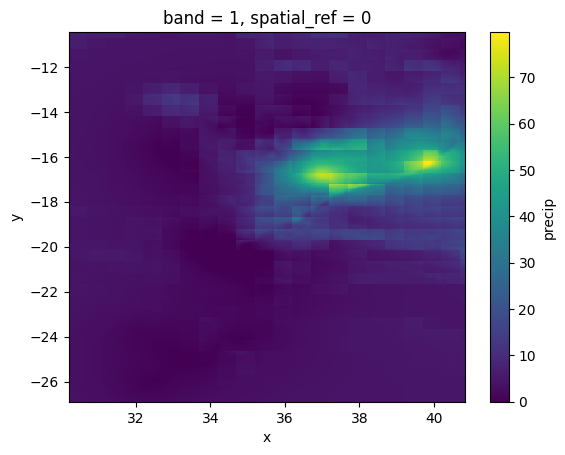

In [12]:
da_in.plot()

In [13]:
# Function to get median rainfall within 250km radius using rioxarray
def get_median_rainfall(tif_path, lon, lat, radius_km, gdf_sel):
    # Open the tif file with rioxarray
    raster = rxr.open_rasterio(tif_path, masked=True).squeeze()

    # Create a circle of 250km radius around the point (lat, lon)
    buffer = Point(lon, lat).buffer(
        radius_km / 110.574
    )  # Roughly 1 degree ~ 110.574 km
    buffer = gdf_sel[gdf_sel.intersects(buffer)].unary_union

    if buffer.is_empty:
        return None

    # Clip the raster using the buffer
    clipped_raster = raster.rio.clip([buffer], gdf_sel.crs, drop=True)

    # Compute the median rainfall within the clipped area
    median_rainfall = np.nanmedian(clipped_raster.values)
    return median_rainfall

In [14]:
# Initialize the output DataFrame
output_df = pd.DataFrame(
    columns=["NAME", "date", "days_to_landfall", "median_rainfall"]
)

# Define the number of days to look around each point's date
days_range = 5  # Adjust this as needed

# Loop through each cyclone (NAME)
for cyclone in landfall_df["NAME"].unique():
    cyclone_df = landfall_df[landfall_df["NAME"] == cyclone].copy()
    cyclone_df["date"] = pd.to_datetime(cyclone_df["date"], dayfirst=True)

    # Find the landfall date (the date when 'actual_within_land' is True)
    landfall_date = cyclone_df[cyclone_df["actual_within_land"]].iloc[0][
        "date"
    ]
    print(cyclone)
    # Process each date for the cyclone
    for index, row in cyclone_df.iterrows():
        # Determine the date range to search for TIF files
        start_date = row["date"] - timedelta(days=days_range)
        end_date = row["date"] + timedelta(days=days_range)
        # Loop through all TIF files in inam_path
        for tif_file in os.listdir(inam_path):
            # Extract date from TIF filename assuming 'chirp_daily_blended_moz_YYYYMMDD.tif' format
            tif_date_str = tif_file.split("_")[-1].split(".")[0]
            tif_date = pd.to_datetime(tif_date_str, format="%Y%m%d")

            # Process the TIF file if its date falls within the desired range
            if start_date <= tif_date <= end_date:
                tif_path = os.path.join(inam_path, tif_file)

                # Compute the median rainfall within the 250km radius
                median_rainfall = get_median_rainfall(
                    tif_path, row["LON"], row["LAT"], 250, gdf_sel
                )

                # Calculate days to landfall
                days_to_landfall = (tif_date - landfall_date).days

                # Create a temporary DataFrame to store the result
                temp_df = pd.DataFrame(
                    {
                        "NAME": [cyclone],
                        "date": [tif_date],  # Use TIF file's date here
                        "days_to_landfall": [
                            days_to_landfall
                        ],  # Calculate days to landfall
                        "median_rainfall": [median_rainfall],
                    }
                )

                # Append the temporary DataFrame to the output DataFrame using pd.concat
                output_df = pd.concat([output_df, temp_df], ignore_index=True)

FAVIO
JOKWE
IZILDA
DANDO
IRINA
HARUNA
DELIWE
HELLEN
DINEO
DESMOND
IDAI 1
IDAI 2
KENNETH
CHALANE
ELOISE
GUAMBE
ANA
GOMBE
JASMINE
FREDDY
FILIPO


In [15]:
output_df

,NAME,date,days_to_landfall,median_rainfall
0,FAVIO,2007-02-21,-1,3.1200
1,FAVIO,2007-02-22,0,1.4405
2,FAVIO,2007-02-23,1,16.2020
3,FAVIO,2007-02-24,2,14.5270
4,FAVIO,2007-02-25,3,32.7340
...,...,...,...,...
75,GUAMBE,2021-02-11,-1,10.5210
76,GUAMBE,2021-02-12,0,12.3700
77,GUAMBE,2021-02-13,1,16.7630
78,GUAMBE,2021-02-14,2,18.8895


In [16]:
output_df.to_csv(
    AA_DATA_DIR
    / "public"
    / "processed"
    / "moz"
    / "inam_cyclone_landfall_data_updated.csv"
)